# Assignment 2 
Alessandro Sardelli 561158

In [ ]:
import cv2
from PIL import Image
import glob
import fnmatch
import os
import numpy as np 
import random
import matplotlib.pyplot as plt
import scipy
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.patches as mpatches


In [ ]:
#Function that allow to build an histogram of all occurrences of the words and a  images-terms matrix (bag of visual words)
def build_histogram(descriptor_list, cluster_alg):
    bovw_matrix =np.zeros(shape=[len(descriptor_list),500])
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    
    j=0
    for d in descriptor_list:
        cluster_result =  cluster_alg.predict(d)
        for i in cluster_result:
            histogram[i] += 1.0
            bovw_matrix[j][i] +=1.0
        j+=1
    return histogram, bovw_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Choose random images to show point of interest
sample=[]
sample=random.sample(range(0, 232), 3)
sample


[110, 39, 98]

In [ ]:
#Dividing test images (8) from training images (232), 
path=r"/content/drive/MyDrive/assign_2/*.bmp"
train_images=[]
test_images=[]
for filename in glob.glob(path):
    if not fnmatch.fnmatch(filename, '*GT.bmp'):
        if not fnmatch.fnmatch(filename, '*30_s.bmp'):
            train_images.append(filename)
        else:
            test_images.append(filename)

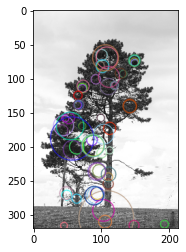

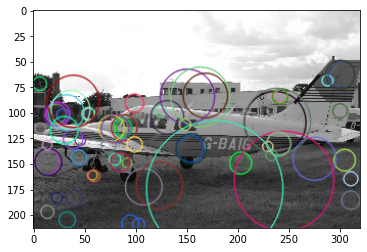

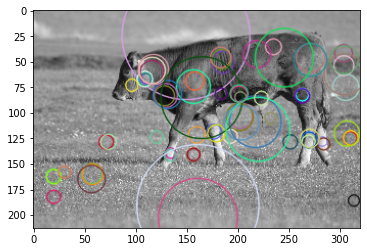

In [ ]:
#Generate for each image points of interest with MSER and relative descriptors with SIFT
train_kp = []
test_kp = []
train_desc = []
test_desc=[]

i=0
for filename in train_images:
  # Image Read
  imgUMat = cv2.imread(filename)
  #Identify key points with MSER detector
  mser = cv2.MSER_create()
  kp = mser.detect(imgUMat)
  # Extract relative SIFT descriptors
  gray= cv2.cvtColor(imgUMat, cv2.COLOR_BGR2GRAY)
  sift = cv2.SIFT_create()
  kp , des = sift.compute( gray, kp)
  train_kp.append(kp)
  train_desc.append(des)
  if i in sample:
    img_1 = cv2.drawKeypoints(gray,kp,imgUMat,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_1)
    plt.show()
  i+=1
for filename in test_images:
  # Image Read
  imgUMat = cv2.imread(filename)
  #Identify key points with MSER detector
  mser = cv2.MSER_create()
  kp = mser.detect(imgUMat)
  # Extract relative SIFT descriptors
  gray= cv2.cvtColor(imgUMat, cv2.COLOR_BGR2GRAY)
  sift = cv2.xfeatures2d.SIFT_create()
  kp , des = sift.compute( gray, kp)
  test_kp.append(kp)
  test_desc.append(des)
  


In [ ]:
#Generate the 500-dimensional codebook with kmeans on all training images
train_desc_mat = np.vstack(train_desc)
kmeans = KMeans(n_clusters = 500)
kmeans.fit(train_desc_mat)

KMeans(n_clusters=500)

In [ ]:
histogram, bovw_matrix= build_histogram(train_desc, kmeans)

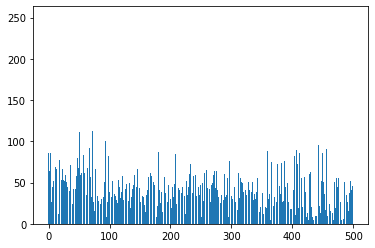

In [ ]:
#Histogram of occurrences of visual words extracted in training images
plt.bar(range(500),histogram,align='center')
plt.show()

In [ ]:
#LDA model
lda = LatentDirichletAllocation(
    n_components=8,
    max_iter=10,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [ ]:
#fit the lda model 
lda.fit(bovw_matrix)


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=8, random_state=0)

In [ ]:
colors=[]
for i in range(8):
    colors.append(tuple(np.random.randint(0, 256, size=3)))


In [ ]:

handles=[]
i=0
for c in colors:
    patch = mpatches.Patch(color=(c[0]/256, c[1]/256, c[2]/256, ), label=i)
    i+=1
    handles.append(patch)


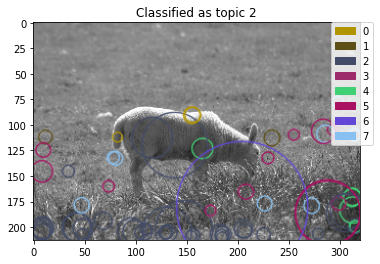

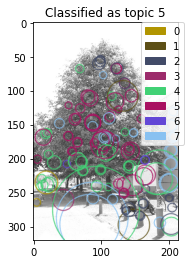

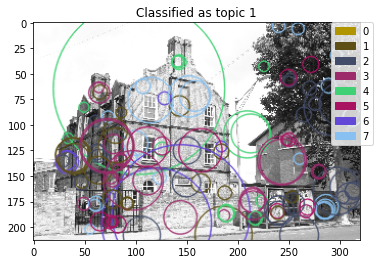

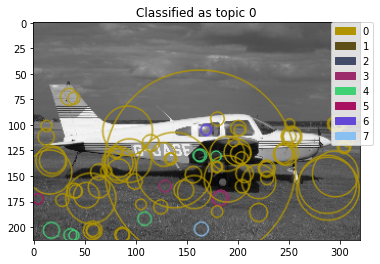

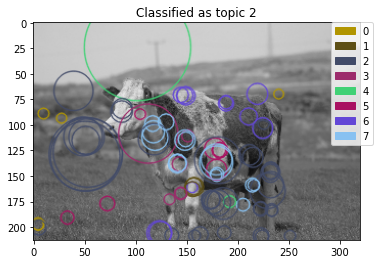

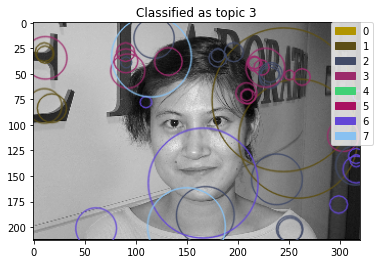

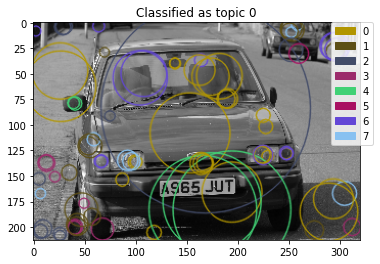

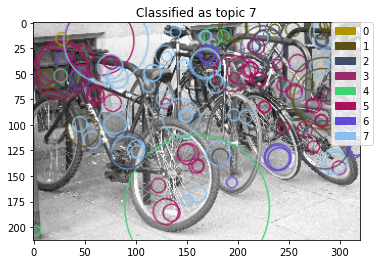

In [ ]:
#Predict topics for test images, highlighting topic classification also for each point of interest inside images
predict_list=[]
#predict each image
h, b_all=build_histogram(test_desc,kmeans)
predict=lda.transform(b_all)
for row in predict:
    predict_list.append(row)
#Predict each keypoints of image
i=0
for d, k in zip(test_desc, test_kp):
    img_1=cv2.imread(test_images[i])
    gray= cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    for kp_d, kp_p in zip(d, k):
        h, b=build_histogram([kp_d.reshape(1,-1)],kmeans)
        predict=lda.transform(b)
        topic=predict.argmax()
        gray=cv2.drawKeypoints(gray,[kp_p],gray,(int(colors[topic][0]),int(colors[topic][1]),int(colors[topic][2])), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.legend(handles=handles, bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.title("Classified as topic "+ str(np.argmax(predict_list[i])))
    plt.imshow(gray)
    plt.show()
    i+=1


# Conclusions

In this assignment, we implement from scratch a simple image understanding application based on LDA model.\
The dataset presented was intuitively divided in 8 class, which provided me with the number of topics to consider for the LDA model.\
The results seems good as we can see for example that images classified as 2 (could vary if rerun) show similarity, infact we found a sheep and a cow on the grass, but also can see some differencies on images predicted as same topic like the plane and the car images (however they still present some similarity like the presence of written text). \
To enhance the model ideally we could use a larger training set, or better, we could carry out a more precise and exhaustive model selection, for example using a greed search  on the number of topics of LDA model, but also on parameter K of k-means when generating the codebook to produce the Bag Of Visual Words.

